1. **训练误差和泛化误差 : 说明数据集{0，1，1，1，0，1}**
    + 统计学习理论:独立同分布假设
    + 模型复杂性:能够轻松解释任意事实的模型是复杂的，而表达能力有限但仍能很好地解释数据的模型可能更有现实用途。
    + 影响模型泛化的几点因素：
        * 可调整参数的数量。
        * 参数采用的值。
        * 训练样本的数量。

***
2. **模型选择**
* 验证集：数据分成三份，除了训练和测试数据集之外
* K 折交叉验证：训练数据稀缺时，采用K折

***
3. **欠拟合还是过拟合？**
* 模型复杂性：多项式的阶数和欠拟合与过拟合之间的关系。
* 数据集大小：模型复杂性和数据集大小之间通常存在关系
 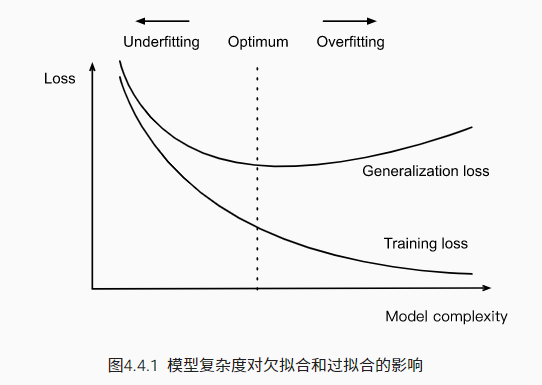

***
4. **多项式回归**
* 生成数据集
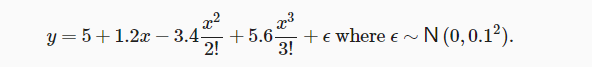
* 对模型进行训练和测试
* 三阶多项式函数拟合(正态)
* 线性函数拟合(欠拟合)
* 高阶多项式函数拟合(过拟合)


In [2]:
'''# 生成数据集'''
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
'''# 构造多项式：y=5+1.2x−3.4x22!+5.6x33!+ϵ where ϵ∼N(0,0.12).'''
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
labels.shape

(200,)

In [7]:
'''# NumPy ndarray转换为tensor'''
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.2068],
         [-0.8295]]),
 tensor([[ 1.0000e+00,  2.0677e-01,  2.1376e-02,  1.4733e-03,  7.6158e-05,
           3.1494e-06,  1.0853e-07,  3.2058e-09,  8.2857e-11,  1.9036e-12,
           3.9359e-14,  7.3984e-16,  1.2748e-17,  2.0276e-19,  2.9945e-21,
           4.1278e-23,  5.3343e-25,  6.4880e-27,  7.4528e-29,  8.1105e-31],
         [ 1.0000e+00, -8.2953e-01,  3.4406e-01, -9.5136e-02,  1.9730e-02,
          -3.2732e-03,  4.5254e-04, -5.3628e-05,  5.5608e-06, -5.1254e-07,
           4.2516e-08, -3.2062e-09,  2.2164e-10, -1.4143e-11,  8.3799e-13,
          -4.6343e-14,  2.4027e-15, -1.1724e-16,  5.4030e-18, -2.3589e-19]]),
 tensor([5.2126, 2.2362]))

In [11]:
'''评估给定数据集上模型的损失。'''
def evaluate_loss(net, data_iter, loss): 
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [9]:
'''# 定义训练函数'''
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0153294  1.2001235 -3.406928   5.6036215]]


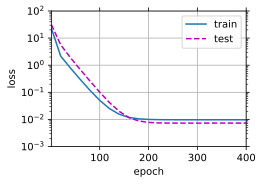

In [12]:
#  三阶多项式函数拟合(正态),从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4384627 3.6459868]]


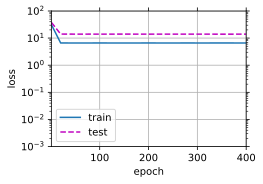

In [13]:
'''# 欠拟合'''
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


weight: [[ 4.9818106   1.2506325  -3.2261684   5.2896667  -0.61140347  1.0159308
   0.08153058  0.11955898 -0.20905285  0.20098005  0.20326565 -0.12454619
   0.02357221 -0.06789128  0.07422747  0.16425401 -0.04536374 -0.1403845
   0.15533704 -0.08340817]]


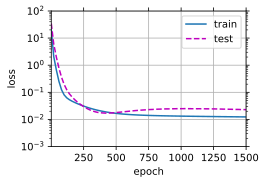

In [14]:
'''过拟合'''
#高阶多项式函数拟合(过拟合)

# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)